In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4

def make_env():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

# Test the environment
env = make_env()
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['speaker_0', 'listener_0']


In [50]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize policies and discriminators

speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3 # [say_0, say_1, say_2, say_3, say_4, say_5, say_6, say_7, say_8, say_9]
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

policies = {
    "speaker_0": Policy(obs_dim=speaker_obs_dim, act_dim=speaker_act_dim),  
    "listener_0": Policy(obs_dim=listener_obs_dim, act_dim=listener_act_dim)   
}

# For Discriminator the output is a single value
discriminators = {
    "speaker_0": Discriminator(obs_dim=3, act_dim=3),   # Speaker: 3 obs + 3 actions
    "listener_0": Discriminator(obs_dim=11, act_dim=5)  # Listener: 11 obs + 5 actions
}

# Initialize value networks
value_nets = {
    "speaker_0": ValueNet(obs_dim=speaker_obs_dim),
    "listener_0": ValueNet(obs_dim=listener_obs_dim)
}


## Plotting functions

## Expert Demonstrations
For simplicity, we use a heuristic expert - but this is not good...

We shall use pre-trained expert policy


In [51]:
env = simple_speaker_listener_v4.parallel_env(max_cycles=25, continuous_actions=False)


In [52]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the expert policy
expert_policies = torch.jit.load("Expert_data/simple_speaker_listener.pt").to(device)
expert_policies.eval()

# Try to retrieve h_dim from the policy, fallback to 128
try:
    h_dim = expert_policies.h_dim
    print(f"Retrieved h_dim: {h_dim}")
except AttributeError:
    h_dim = 128  # From error message
    print("h_dim not accessible, using 128")

def expert_policy(obs, rnn_actor, deterministic=True):
    with torch.no_grad():
        # Convert observations to tensors
        obs_speaker = torch.FloatTensor(obs["speaker_0"]).to(device)
        obs_listener = torch.FloatTensor(obs["listener_0"]).to(device)
        # Pad speaker's observation (3) to match listener’s (11)
        obs_speaker_padded = torch.nn.functional.pad(obs_speaker, (0, 11 - 3))
        obs_batch = torch.stack([obs_speaker_padded, obs_listener], dim=0)
        
        # Define masks and available actions
        masks = torch.ones((2, 1), dtype=torch.bool, device=device)  # For 2 agents
        avails = torch.ones((2, 5), dtype=torch.float32, device=device)  # Assuming 5 actions per agent
        
        # Forward pass through the policy
        actions, _, new_rnn_actor = expert_policies._forward(
            obs_batch, rnn_actor, masks, avails, deterministic
        )
        actions_dict = {
            "speaker_0": actions[0].item(),
            "listener_0": actions[1].item()
        }
        return actions_dict, new_rnn_actor

def generate_expert_data(num_episodes=50):
    env = make_env()  # Assuming this is defined elsewhere
    expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        # Initialize rnn_actor with shape (n_agents, 1, h_dim) on device
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while not done:
            actions, rnn_actor = expert_policy(obs, rnn_actor, deterministic=True)
            for agent in env.agents:
                expert_data[agent]["states"].append(obs[agent])
                expert_data[agent]["actions"].append(actions[agent])
            obs, _, done, _, _ = env.step(actions)

    env.close()
    return expert_data

# Generate data
expert_data = generate_expert_data(num_episodes=50)

Retrieved h_dim: 128


In [55]:
import matplotlib.pyplot as plt

import torch
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4

def evaluate_policy(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    success_rates = []
    avg_rewards = []
    avg_steps = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        speaker_obs = obs["speaker_0"]
        goal_index = np.argmax(speaker_obs)
        done = {"speaker_0": False, "listener_0": False}
        total_reward = 0
        steps = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        # Compute fixed goal position at start
        state = env.state()
        listener_pos = state[4:6]
        goal_pos = state[8 + 2 * goal_index : 10 + 2 * goal_index]  # Static landmark position

        # Debug: Initial state
        if episode < 2:
            print(f"Episode {episode} Start: Listener = {listener_pos}, Goal = {goal_pos}, Goal Index = {goal_index}, Speaker Obs = {speaker_obs}")

        while not all(done.values()):
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())
            steps += 1

            # Compute current listener position
            state = env.state()
            listener_pos = state[4:6]
            distance = np.linalg.norm(listener_pos - goal_pos)  # Use fixed goal_pos

            # Debug: Step details
            if episode < 2 and steps <= 3:
                print(f"Step {steps}: Actions = {actions}, Listener = {listener_pos}, Goal = {goal_pos}, Distance = {distance}, Reward = {sum(rewards.values())}")

        distance = np.linalg.norm(listener_pos - goal_pos)  # Final distance with fixed goal_pos
        success = 1 if distance < threshold else 0

        success_rates.append(success)
        avg_rewards.append(total_reward)
        avg_steps.append(steps)

        if episode < 2:
            print(f"Episode {episode} End: Success = {success}, Reward = {total_reward}, Steps = {steps}, Final Distance = {distance}")

    env.close()
    return {
        "success_rate": np.mean(success_rates),
        "avg_reward": np.mean(avg_rewards),
        "avg_steps": np.mean(avg_steps)
    }

expert_eval = evaluate_policy(expert_policy, num_episodes=50)
print("Expert Policy Evaluation:", expert_eval)



Episode 0 Start: Listener = [0.         0.05140734], Goal = [0.4060055 0.       ], Goal Index = 1, Speaker Obs = [0.15 0.65 0.15]
Step 1: Actions = {'speaker_0': 0, 'listener_0': 2}, Listener = [0.         0.05140734], Goal = [0.4060055 0.       ], Distance = 0.40924710035324097, Reward = -1.0345560408656842
Step 2: Actions = {'speaker_0': 0, 'listener_0': 2}, Listener = [0.         0.00140734], Goal = [0.4060055 0.       ], Distance = 0.40600794553756714, Reward = -0.9159713189207666
Step 3: Actions = {'speaker_0': 0, 'listener_0': 2}, Listener = [ 0.         -0.08609266], Goal = [0.4060055 0.       ], Distance = 0.4150330424308777, Reward = -0.7325105555171607
Episode 0 End: Success = 0, Reward = -9.07259237228135, Steps = 26, Final Distance = 0.6569334864616394
Episode 1 Start: Listener = [0.        0.6547794], Goal = [-0.42295668  0.        ], Goal Index = 1, Speaker Obs = [0.15 0.65 0.15]
Step 1: Actions = {'speaker_0': 0, 'listener_0': 2}, Listener = [0.        0.6547794], Goal =

In [58]:
# Generate expert data and validate
# expert_data = generate_expert_data(num_episodes=50)
# Evaluate the expert policy
expert_eval = evaluate_policy(expert_policy, num_episodes=50)
print("Expert Policy Evaluation:", expert_eval)
# print("Expert Success Rate:", expert_eval['success_rate'])


Episode 0 Start: Listener = [0.         0.32962254], Goal = [0. 0.], Goal Index = 2, Speaker Obs = [0.15 0.15 0.65]
Step 1: Actions = {'speaker_0': 2, 'listener_0': 2}, Listener = [0.         0.32962254], Goal = [0. 0.], Distance = 0.3296225368976593, Reward = -0.08006231832198152
Step 2: Actions = {'speaker_0': 2, 'listener_0': 2}, Listener = [0.         0.27962255], Goal = [0. 0.], Distance = 0.27962255477905273, Reward = -0.0627826093451403
Step 3: Actions = {'speaker_0': 2, 'listener_0': 1}, Listener = [0.         0.19212255], Goal = [0. 0.], Distance = 0.19212254881858826, Reward = -0.05660561863566819
Episode 0 End: Success = 0, Reward = -1.5496400539216717, Steps = 26, Final Distance = 0.17915967106819153
Episode 1 Start: Listener = [0.        1.2770889], Goal = [0.83463776 0.83238137], Goal Index = 0, Speaker Obs = [0.65 0.15 0.15]
Step 1: Actions = {'speaker_0': 1, 'listener_0': 2}, Listener = [0.        1.2770889], Goal = [0.83463776 0.83238137], Distance = 0.9457192420959473

In [ ]:
def learned_policy(obs, _):
    actions = {}
    for agent in obs.keys():
        obs_tensor = torch.FloatTensor(obs[agent])
        action_probs = policies[agent](obs_tensor)
        action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

## Define MAGAIL Networks

In [19]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize policies and discriminators

speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3 # [say_0, say_1, say_2, say_3, say_4, say_5, say_6, say_7, say_8, say_9]
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

policies = {
    "speaker_0": Policy(obs_dim=speaker_obs_dim, act_dim=speaker_act_dim),  
    "listener_0": Policy(obs_dim=listener_obs_dim, act_dim=listener_act_dim)   
}

# For Discriminator the output is a single value
discriminators = {
    "speaker_0": Discriminator(obs_dim=3, act_dim=3),   # Speaker: 3 obs + 3 actions
    "listener_0": Discriminator(obs_dim=11, act_dim=5)  # Listener: 11 obs + 5 actions
}

# Initialize value networks
value_nets = {
    "speaker_0": ValueNet(obs_dim=speaker_obs_dim),
    "listener_0": ValueNet(obs_dim=listener_obs_dim)
}


## Training MAGAIL

In [57]:
def train_magail(expert_data, num_epochs=1000, batch_size=32):
    # Optimizers
    optimizers = {
        agent: {
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=1e-3),
            "disc": torch.optim.Adam(discriminators[agent].parameters(), lr=1e-3),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=1e-3)
        } for agent in ["speaker_0", "listener_0"]
    }
    
    for epoch in range(num_epochs):
        # --- Collect policy trajectories ---
        env = make_env()
        policy_data = {agent: {"states": [], "actions": []} for agent in env.agents}
        obs, _ = env.reset()
        done = False
        
        while not done:
            actions = {}
            for agent in env.agents:
                obs_tensor = torch.FloatTensor(obs[agent])
                action_probs = policies[agent](obs_tensor)
                # Simpling from action distribution - enables exploration during training
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
            
            obs, _, done, _, _ = env.step(actions)
        
        # --- Update discriminators ---
        for agent in ["speaker_0", "listener_0"]:
            # Expert data
            expert_states = torch.FloatTensor(expert_data[agent]["states"])
            expert_actions = torch.LongTensor(expert_data[agent]["actions"])
            
            # Policy data
            policy_states = torch.FloatTensor(policy_data[agent]["states"])
            policy_actions = torch.LongTensor(policy_data[agent]["actions"])

             # One-hot encode actions (different for speaker/listener)
            if "speaker" in agent:
                num_classes = 3  # Speaker has 3 actions
            else:
                num_classes = 5  # Listener has 5 actions
            
            expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float()
            policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float()
            
            # Discriminator loss
            # TODO # Discriminator loss: max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))], 
            # but the formula given by the paper is inversed
            real_loss = -torch.log(discriminators[agent](expert_states, expert_actions_onehot)).mean()
            fake_loss = -torch.log(1 - discriminators[agent](policy_states, policy_actions_onehot)).mean()
            disc_loss = real_loss + fake_loss
            
            optimizers[agent]["disc"].zero_grad()
            disc_loss.backward()
            optimizers[agent]["disc"].step()
        
        # --- Update policies (centralized training) ---
        for agent in ["speaker_0", "listener_0"]:
            states = torch.FloatTensor(policy_data[agent]["states"])
            actions = torch.LongTensor(policy_data[agent]["actions"])
            # One-hot encode actions
            if "speaker" in agent:
                num_classes = 3
            else:
                num_classes = 5
            actions_onehot = torch.nn.functional.one_hot(actions, num_classes=num_classes).float()
            
            # TODO Here we did not use a base line as described in the paper?

            # Adversarial reward: log(D(s,a))
            # It seems to be: D(s,a) How much u think it is from the expert, so we wanna maximize this reward
            # In paper it can be -log(D(s,a)) which outputs the probability that (s,a) from the policy
            with torch.no_grad():
                rewards = torch.log(discriminators[agent](states, actions_onehot))

                # Compute value baseline
                values = value_nets[agent](states)
                # Compute advantages (reward-to-go - baseline)
                advantages = rewards - values.squeeze()

            # Update value network (MSE Loss)
            value_loss = (values.squeeze() - rewards).pow(2).mean()
            # Clear the gradient
            optimizers[agent]["value"].zero_grad()
            value_loss.requires_grad = True
            value_loss.backward()
            optimizers[agent]["value"].step()

            # Policy gradient
            action_probs = policies[agent](states)
            log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))

            # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
            policy_loss = -(log_probs * advantages.detach()).mean()
            
            optimizers[agent]["policy"].zero_grad()
            policy_loss.backward()
            optimizers[agent]["policy"].step()
        
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} Disc Loss: {disc_loss.item():.3f}, Policy Loss: {policy_loss.item():.3f}")
            # eval_stats = evaluate_policy(learned_policy, num_episodes=20)
            # print(f"Epoch {epoch}: Success Rate={eval_stats['success_rate']:.2f}, Avg Reward={eval_stats['avg_reward']:.2f}")

    env.close()
train_magail(expert_data)

Epoch 0 Disc Loss: 1.378, Policy Loss: -1.545
Epoch 10 Disc Loss: 1.390, Policy Loss: -1.415
Epoch 20 Disc Loss: 1.348, Policy Loss: -1.242
Epoch 30 Disc Loss: 1.275, Policy Loss: -1.722
Epoch 40 Disc Loss: 1.274, Policy Loss: -1.438
Epoch 50 Disc Loss: 1.338, Policy Loss: -1.145
Epoch 60 Disc Loss: 1.331, Policy Loss: -1.394
Epoch 70 Disc Loss: 1.303, Policy Loss: -1.504
Epoch 80 Disc Loss: 1.423, Policy Loss: -1.147
Epoch 90 Disc Loss: 1.299, Policy Loss: -1.337
Epoch 100 Disc Loss: 1.305, Policy Loss: -1.022
Epoch 110 Disc Loss: 1.371, Policy Loss: -1.337
Epoch 120 Disc Loss: 1.122, Policy Loss: -1.500
Epoch 130 Disc Loss: 1.093, Policy Loss: -1.580
Epoch 140 Disc Loss: 1.261, Policy Loss: -1.269
Epoch 150 Disc Loss: 1.335, Policy Loss: -1.478
Epoch 160 Disc Loss: 1.333, Policy Loss: -0.860
Epoch 170 Disc Loss: 1.130, Policy Loss: -1.810
Epoch 180 Disc Loss: 1.227, Policy Loss: -0.727
Epoch 190 Disc Loss: 1.290, Policy Loss: -1.368
Epoch 200 Disc Loss: 1.224, Policy Loss: -1.010
Epo

KeyboardInterrupt: 

## Test the Learned Policy

In [48]:
# Evaluate expert policy
expert_stats = evaluate_policy(expert_policy, num_episodes=100, is_expert=True)

# Evaluate learned policy
learned_stats = evaluate_policy(learned_policy, num_episodes=100)

# (Optional) Evaluate random policy
def random_policy(obs, _):
    return {agent: env.action_space(agent).sample() for agent in obs.keys()}
random_stats = evaluate_policy(random_policy, num_episodes=100)

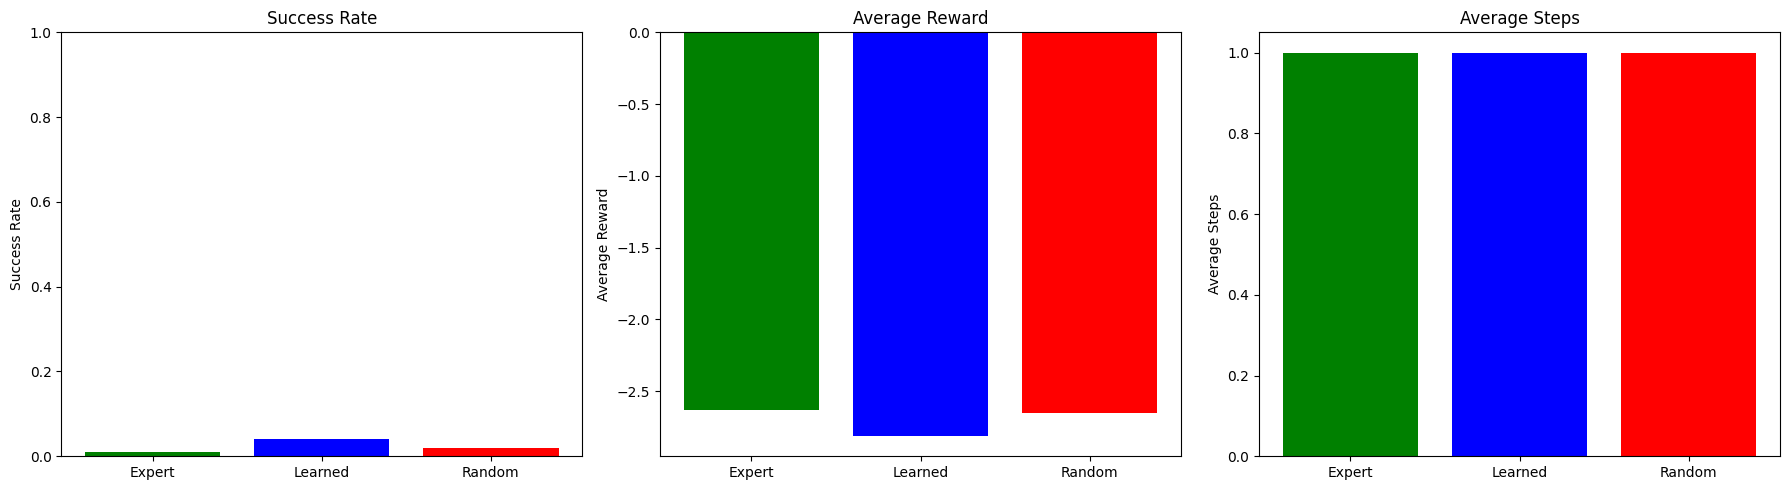

In [50]:
labels = ['Expert', 'Learned', 'Random']
metrics = ['success_rate', 'avg_reward', 'avg_steps']
titles = ['Success Rate', 'Average Reward', 'Average Steps']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    expert_val = expert_stats[metric]
    learned_val = learned_stats[metric]
    random_val = random_stats[metric]
    
    axes[idx].bar(labels, [expert_val, learned_val, random_val], color=['green', 'blue', 'red'])
    axes[idx].set_title(title)
    axes[idx].set_ylabel(title)
    
    if metric == 'success_rate':
        axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()